# Lab 9-4: Batch Normalization

# Bactch Normalization

- Gradient Vanishing / Exploding
- Internal Covariate Shift
- Batch Normalization
- Code: mnist_batchnorm

# Gradient Vanishing / Exploding

- Gradient Vanishing : gradient가 너무 작아지면서 소멸 하게 되는 문제
- Gradient Exploding : gradient가 너무 커지면서 발산 하게 되는 문제

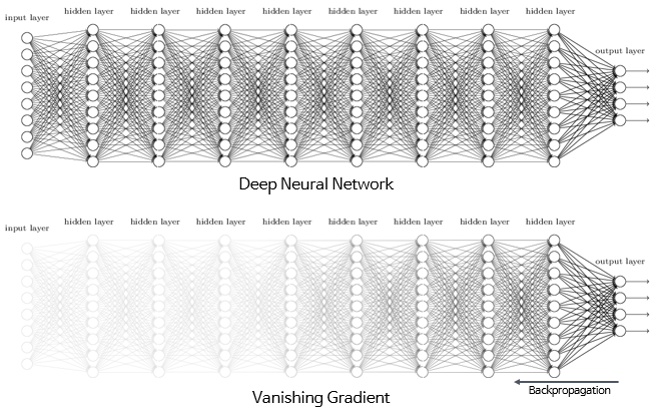

# Internal Covariate Shift

먼저, **Covariate Shift**란?  
학습하는 도중에 이전 layer의 파라미터 변화로 인해 현재 layer의 입력의 분포가 바뀌는 현상을 말한다.
- 우리는 Covariate Shift 문제에 대응하기 위해서 input과 output의 차이를 줄이기 위해서 입력 데이터를 Normalize해서 neural network에 사용했다.
- 그런데 Covariate Shift 문제는 모델 전체의 input과 output이 아닌, 각각의 layer의 input과 output마다 발생을 했다. 이를 **ICS(Internal Covariate Shift)**라고 한다.
- 이 ICS를 해결하기 위해 나온 게 **Bactch Normalization**이다.

# Batch Normalization

**Batch Normalization**이란?
ICS를 해결하기 위해서 각 layer들마다 Normalizaion을 해준다.
- 일반적으로 neural network를 학습을 할 때 사용되는 mini-batch마다 normalizaion을 해준다.

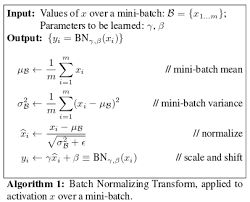

- mini-batch의 데이터가 달라질때마다 μ와 variation이 달라지기에, 같은 샘플마다 다른 결과를 낼 수 있다는 문제점이 있다.
- 이를 해결하기 위해, learning mean과 learning variance를 사용한다.

learning mean과 learning variance란?  
어떤 batch로부터 학습을 하며 구한 sample mean과 sample variance를 각각 저장하고, 저장된 sample mean들과 sample variance들의 평균을 이용해 구한 값
- 학습이 끝나도, 입력 batch와 상관 없는 고정값이다.

# Code: mnist_batchnorm 

In [8]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
else:
    torch.manual_seed(777)
    
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.3

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [3]:
# nn layers
# bactch normalization 사용
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

# bactch normalization 사용 안함
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [4]:
# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [5]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [9]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')


[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.16856(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.28927(nn_acc:0.92)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.17362(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.28516(nn_acc:0.92)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.11136(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.22551(nn_acc:0.93)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12668(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.22725(nn_acc:0.93)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09093(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17938(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11362(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.18566(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07541(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.16384(nn_acc:0.95)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.11195(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17328(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [10]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

In [ ]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')